# <font color="#5fa8d3"> Yolo model


## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation, Parameters & Funtions Definition](#id0)<br>
1. [Preparation of the data](#id1)<br>
    1.1 [Copy Images to Yolo Folder](#id11)<br>
    1.2 [Obtain the labels for YOLO](#id12)<br>
2. [Yolo Model Trainings in Sagemaker](#id2)<br>
    2.1 [Upload data to AWS S3](#id21)<br>
    2.2 [Include Credentials for Sagemaker](#id22)<br>
    2.3 [Hyperparameter tuning in Sagemaker](#id23)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.1 [Hyperparameters space and tuning code for Sagemaker](#id231)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.2 [Select best tuning model and metrics](#id232)<br>
3. [Train with the Final Model](#id3)<br>
    3.1 [Train and Validation Datasets for the final train](#id31)<br>
    3.2 [Retrain the Final Model in Sagemaker](#id32)<br>
4. [Generalization Check](#id4)<br>
5. [Conclusions](#id5)<br>

## <font color="#62b6cb"> 0. Libraries Importation, Parameters & Funtions Definition <a name="id0"></a>

In [1]:
import json
import os
from ultralytics import YOLO
import shutil
import yaml # for importing a yaml file
import joblib
import torch
import subprocess
from io import BytesIO
import tarfile
import pandas as pd



import boto3
import tarfile
import joblib

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner, 
                            HyperbandStrategyConfig, StrategyConfig, HyperparameterTuningJobAnalytics)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
current_directory = os.getcwd()
last_folder = os.path.basename(current_directory)
    
if last_folder != "project-danielteresa":
    while last_folder != "project-danielteresa":
        parent_directory = os.path.dirname(current_directory)
        last_folder = os.path.basename(parent_directory)

        os.chdir(parent_directory)
        print(f"Changed directory to: {parent_directory}")
else:
    print("Already in the project root directory.")

# our modules
from src.mymodule import * # for importing our functions

Changed directory to: /home/sagemaker-user/project-danielteresa


**Configuration Variables**

In [3]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123
color1: #62b6cb
color2: #fb8500
color3: #023047
color4: #FFB703
path_annotations: ./Data
path_train: ./Data/train/original
path_train_train: ./Data/train/train
path_train_aug: ./Data/train/train_aug
path_train_val: ./Data/train/val
path_test: ./Data/test
path_yolo: ./Data/Yoloimages/
path_models: ./Models
path_yaml_yolo: ./Notebooks/data.yaml
path_yaml_yolo_tune_metrics: ./Notebooks/data_tune_metrics.yaml
path_yaml_yolo_train_final: ./Notebooks/data_train_final.yaml
path_yaml_yolo_train_final_metrics: ./Notebooks/data_train_final_metrics.yaml
path_yaml_yolo_test: ./Notebooks/data_test.yaml
folder_tuning: tuning_data
folder_final: final_data
kaggle_train_annotations: annotations_train.json
train_annotations_name_temp: annotations_train_temp.json
train_annotations_name: annotations_train_updated.json
aug_train_annotations_name: annotations_train_updated_aug.json
val_annotations_name: annotations_val_updated.json
kaggle_test_annotations: annotations

## <font color="#62b6cb"> 1. Preparation of data <a name="id1"></a>

### <font color="#62b6cb"> 1.1 Copy Images to Yolo Folder  <a name="id11"></a> 

In [4]:
# Create the folders if they don't exist
directories = [
    os.path.join(path_yolo, "train/images"),
    os.path.join(path_yolo, "train/labels"),
    os.path.join(path_yolo, "val/images"),
    os.path.join(path_yolo, "val/labels"),
    os.path.join(path_yolo, "test/images"),
    os.path.join(path_yolo, "test/labels")
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Remove everything that exists in the folders
for directory in [    os.path.join(path_yolo, "train/images"),
                      os.path.join(path_yolo, "train/labels"),
                      os.path.join(path_yolo, "val/images"),
                      os.path.join(path_yolo, "val/labels"),
                      os.path.join(path_yolo, "test/images"),
                      os.path.join(path_yolo, "test/labels")]:
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Copy images from train augmented to Yolo train folder
shutil.copytree(path_train_aug, os.path.join(path_yolo, "train/images"), dirs_exist_ok=True)
shutil.copytree(path_train_val, os.path.join(path_yolo, "val/images"), dirs_exist_ok=True)
shutil.copytree(path_test, os.path.join(path_yolo, "test/images"), dirs_exist_ok=True)

print("Folders have been cleaned and files have been copied successfully.")

Folders have been cleaned and files have been copied successfully.


Check the annotations and id of the coco jsons

In [5]:
print("Check that annotation for training is correct")
print(validate_coco_dataset(os.path.join(path_annotations,aug_train_annotations_name), os.path.join(path_yolo,"train/images")))

print("Check that annotation for validation is correct")
print(validate_coco_dataset(os.path.join(path_annotations,val_annotations_name), os.path.join(path_yolo,"val/images")))

print("Check that annotation for test is correct")
print(validate_coco_dataset(os.path.join(path_annotations,test_annotations_name), os.path.join(path_yolo,"test/images")))

Check that annotation for training is correct
True
Check that annotation for validation is correct
True
Check that annotation for test is correct
True


Some of the points of the polygons are out of the range of the width and the height

In [6]:
# Some of the points of the polygons are out of the range of the images

# train
process_coco_annotations(os.path.join(path_annotations,aug_train_annotations_name),
                          os.path.join(path_annotations,aug_train_annotations_name))

# val
process_coco_annotations(os.path.join(os.path.join(path_annotations,val_annotations_name)), 
                         os.path.join(os.path.join(path_annotations,val_annotations_name)) )

In [7]:
with open(os.path.join(path_annotations, train_annotations_name), 'r') as f:
    coco_data = json.load(f)

# Extract image sizes
widths = []
heights = []

for image in coco_data['images']:
    widths.append(image['width'])
    heights.append(image['height'])

# Find the range of widths and heights
min_width = min(widths)
max_width = max(widths)
min_height = min(heights)
max_height = max(heights)

print(f"Width range: {min_width} to {max_width}")
print(f"Height range: {min_height} to {max_height}")

Width range: 204 to 2365
Height range: 153 to 2560


### <font color="#62b6cb"> 1.2 Obtain the labels for YOLO  <a name="id12"></a> 

Obtain the yolo txt for each images from the coco data annotations using the conver_coco from ultralytics. The annotations json to convert should be in a folder with that json in it.

In [8]:
# Obtain the yolo labels
# train
convert_coco_to_yolo_segmentation(path_annotations, aug_train_annotations_name, path_yolo, 'train')
# val
convert_coco_to_yolo_segmentation(path_annotations, val_annotations_name, path_yolo, 'val')
# test
convert_coco_to_yolo_segmentation(path_annotations, test_annotations_name, path_yolo, 'test')

Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train/annotations_train_updated_aug.json: 100%|██████████| 18594/18594 [00:06<00:00, 3080.51it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/train/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/annotations_val_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 12146.16it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/val/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/annotations_test_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 12281.21it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/test/labels



We check the nº of elememts in the folder:

In [9]:
# Define the directory path
directory_path = path_yolo +'/train/labels'

# List all files in the directory
files = os.listdir(directory_path)

# Count the number of files
file_count = len([file for file in files if os.path.isfile(os.path.join(directory_path, file))])

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in './Data/Yoloimages//train/labels': 18594


## <font color="#62b6cb"> 2. Yolo Model Trainings in Sagemaker  <a name="id2"></a> 




### <font color="#62b6cb"> 2.1. Upload data to AWS S3  <a name="id21"></a> 

We upload the files to S3:

In [14]:
bucket_test = f"{bucket_name}/test"
local_test = "Data/Yoloimages/test"

upload_folder_to_s3(local_test, bucket_test)

Uploading Data/Yoloimages/test: 100%|██████████| 4649/4649 [00:25<00:00, 182.08file/s]


0

In [11]:

# data sets are uploaded to the main directory of S3
# Define the bucket name and the folder to copy to S3
bucket_train = f"{bucket_name}/train"
local_train = "Data/Yoloimages/train"

bucket_val = f"{bucket_name}/val"
local_val = "Data/Yoloimages/val"

bucket_test = f"{bucket_name}/test"
local_test = "Data/Yoloimages/test"

# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)
upload_folder_to_s3(local_test, bucket_test)



#Train and val are uploaded to the folder that is going to be the evironment of training in Tuning
# Define the bucket name and the folder to copy to S3
bucket_train = f"{bucket_name}/{folder_tuning}/train"
local_train = "Data/Yoloimages/train"

bucket_val = f"{bucket_name}/{folder_tuning}/val"
local_val = "Data/Yoloimages/val"
# Upload train  and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)



#  THe folder for the final training is created
# val and training are moved to  the same folder
# Define the bucket name and the folder to copy to S3
bucket_train1 = f"{bucket_name}/{folder_final}/train"
local_train = "Data/Yoloimages/train"

bucket_train2 = f"{bucket_name}/{folder_final}/train" #
local_val = "Data/Yoloimages/val"

upload_folder_to_s3(local_train, bucket_train1)
upload_folder_to_s3(local_val, bucket_train2)

# for AWS even if I specify that val is not done, it has to exist a val folder
bucket_val = f"{bucket_name}/{folder_final}/val" #
local_val = "Data/Yoloimages/val"

upload_folder_to_s3(local_val, bucket_val)



Uploading Data/Yoloimages/val: 100%|██████████| 4648/4648 [00:26<00:00, 178.35file/s]


0

In [12]:
bucket_train1 = f"{bucket_name}/train_final"
local_train = "Data/Yoloimages/train"

bucket_train2 = f"{bucket_name}/train_final" #
local_val = "Data/Yoloimages/val"

upload_folder_to_s3(local_train, bucket_train1)
upload_folder_to_s3(local_val, bucket_train2)

Uploading Data/Yoloimages/val: 100%|██████████| 4648/4648 [00:25<00:00, 181.06file/s]


0

In [16]:
print("Folder for training final model")
prefix = f"{folder_final}/train/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = f"{folder_final}/train/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')


print("\n Folder for tuning final model")

prefix = f"{folder_tuning}/train/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = f"{folder_tuning}/train/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = f"{folder_tuning}/val/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = f"{folder_tuning}/val/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

print("\n Folders")
prefix = "train/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = "train/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')


prefix = "val/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = "val/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = "test/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = "test/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')


prefix = "train_final/labels"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

prefix = "train_final/images"
total_objects = count_s3_objects(bucket_name,  prefix)
print(f'Total objects in {prefix}: {total_objects}')

Folder for training final model
Total objects in final_data/train/images: 20918
Total objects in final_data/train/labels: 20918

 Folder for tuning final model
Total objects in tuning_data/train/images: 18594
Total objects in tuning_data/train/labels: 18594
Total objects in tuning_data/val/images: 2324
Total objects in tuning_data/val/labels: 2324

 Folders
Total objects in train/labels: 18594
Total objects in train/images: 18594
Total objects in val/labels: 2324
Total objects in val/images: 2324
Total objects in test/labels: 2324
Total objects in test/images: 2325
Total objects in train_final/labels: 20918
Total objects in train_final/images: 20918


To avoid space issues during training in SageMaker, the validation and training folders are copied to a folders with only the necessary data. This path is then passed to the training process, allowing it to access the necessary data without downloading the entire contents of the S3 bucket.

Now we upload the annotations the data.yaml file for train the model too:

In [18]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information

train_path = 'train/images'
path_yolo_val = 'val/images'

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)

# Create the YAML file
create_yaml_file(path_yaml_yolo, train_path, path_yolo_val, nc, names)

yolo = YOLO(os.path.join(weights_yolo_path_original, variant_yolo))
 # downloading the original weights in case github does not work and it is not
# able to download the weights from ultralytics' repository

In [20]:
# Upload the file to the specified S3 bucket
upload_file_to_s3(path_yaml_yolo, bucket_name)

# Upload the file to the specified S3 bucket
upload_file_to_s3(os.path.join(weights_yolo_path_original, variant_yolo), bucket_name)

Successfully uploaded ./Notebooks/data.yaml to s3://sagemaker-eu-west-1-project-danielteresa/data.yaml
Successfully uploaded Models/yolo_weights/yolov8m-seg.pt to s3://sagemaker-eu-west-1-project-danielteresa/yolov8m-seg.pt


We already create the prueba images and upload (this folders were created for testing the code and are selected randomly):

In [29]:
# Folder Set up
train_folder = './Data/Yoloimages/train'
val_folder = './Data/Yoloimages/val'

destination_train_folder = './Data/Yoloimages/train_prueba'
destination_val_folder = './Data/Yoloimages/val_prueba'

# Seleccionar 20 imágenes de cada carpeta
select_images(train_folder, destination_train_folder, 20, 'images', 'labels', seed)
select_images(val_folder, destination_val_folder, 20, 'images', 'labels', seed)

In [30]:
# Define the bucket name and the folder to copy to S3
bucket_train = f"{bucket_name}//train_prueba"
local_train = "Data/Yoloimages/train_prueba"

bucket_val = f"{bucket_name}//val_prueba"
local_val = "Data/Yoloimages/val_prueba"


# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)

Uploading Data/Yoloimages/val_prueba: 100%|██████████| 40/40 [00:00<00:00, 51.80file/s]


0

In [21]:

# Copy data.yaml of s3 to tuning_data
source_key = 'data.yaml'
destination_key = f'{folder_tuning}/data.yaml'
s3 = boto3.resource('s3')
# Copy the file to the new location
copy_source = {'Bucket': bucket_name, 'Key': source_key}
s3.Object(bucket_name, destination_key).copy(copy_source)

print(f"File copied from {source_key} to {destination_key}")

File copied from data.yaml to tuning_data/data.yaml


The weights of yolov8m are moved to the folders so it will not depend if github is working when training

In [22]:

s3 = boto3.resource('s3')

# move weights for tuning
destination_key = f'{folder_tuning}/{variant_yolo}'
# Copy the file to the new location
copy_source = {'Bucket': bucket_name, 'Key': variant_yolo}
s3.Object(bucket_name, destination_key).copy(copy_source)

print(f"File moved from {variant_yolo} to {destination_key}")

# move weights for final
destination_key = f'{folder_final}/{variant_yolo}'
# Copy the file to the new location
copy_source = {'Bucket': bucket_name, 'Key': variant_yolo}
s3.Object(bucket_name, destination_key).copy(copy_source)

print(f"File copied from {variant_yolo} to {destination_key}")



File moved from yolov8m-seg.pt to tuning_data/yolov8m-seg.pt
File copied from yolov8m-seg.pt to final_data/yolov8m-seg.pt


### <font color="#62b6cb"> 2.2. Include Credentials for Sagemaker  <a name="id22"></a> 

We define the credentials to run the trainning job

In [5]:
########### ADD HERE CREDENTIALS ############
##############################################

###########################################

sts_client = boto3.client('sts')

role_arn = 'arn:aws:iam::794367255496:role/daniel.quesada10'  # Replace with your actual role ARN

assumed_role = sts_client.assume_role(
    RoleArn=role_arn,
    RoleSessionName='SageMakerSession'
)

credentials = assumed_role['Credentials']

# Use the assumed role credentials to create a new session
sagemaker_session = sagemaker.Session(
    boto3.Session(
        aws_access_key_id=credentials['AccessKeyId'],
        aws_secret_access_key=credentials['SecretAccessKey'],
        aws_session_token=credentials['SessionToken'],
    )
)


### <font color="#62b6cb"> 2.3 Hyperparameter tuning in Sagemaker  <a name="id23"></a> 





#### <font color="#62b6cb"> 2.3.1 Hyperparameters space and tuning code for Sagemaker  <a name="id231"></a> 


As yolo is not a model from AWS, it is necessary to define a regex expression, so when the metrics are printed in the screen is able to detect them.

In [5]:

metric_definitions = [
    {
        "Name": "box_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "cls_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "dfl_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "mAP50", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)\\s+\\d+\\.\\d+"
    },
    {
        "Name": "mAP50-95", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)"
    }
]


hyperparameter_ranges = {
    # 'batch': CategoricalParameter([32, 64, 128]),
    'lr0': CategoricalParameter([1e-4, 1e-3]),
    'lrf': CategoricalParameter([0.01, 0.1, 0.5, 1]),
    'momentum': CategoricalParameter([0.8, 0.9, 0.98]),
    'weight_decay': CategoricalParameter([0.0001, 0.001, 0.01])
}

We define the **train_tune.py** file for training in Sagemaker. This file defines de yolo model and the parameters that the HyperparameterTuner needs to replace.

In [6]:
%%writefile Sagemaker/train_tune.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument('--patience',type=int, help='patience value')
    parser.add_argument("--batch", type=int, help='batch size')
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

  
    # Train the YOLO model
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     patience=args.patience,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

Overwriting Sagemaker/train_tune.py


Regarding hyperparameters we are going to do the following:

+ epochs: We will not tune this parameter as we are already including hyperparameters to tackle the overfitting. We will assume a big enough number so that the model does not underfit. Besides YOLO model selects the weights of the best performance epoch.
+ batch size: For the tuning we just try powers of 2 as it is recommended for parallel calculation efficiency. to reduce the computing time we will try medium / high batch sizes (minimum of 32), but for this we will need to use GPU instance from Sagemaker as are more appropiate for deep learning model training
+ Learning Rate: As we will be using a random seach instead of a hyperband method we will be using a list of given parameters as suggested in this [article](https://www.sciencedirect.com/science/article/pii/S2666827022000433).
+ Learning rate factor (decay the learning rate over time): Again as we will be using a random seach instead of a hyperband method we will be using a list of given parameters as it would lead to faster convergence and lower computational costs. Still we have removed the 0.1 and the 1e-5 as both are quite extreme in both directions.
+ momentum: It control the exponential decay rates for the moment estimates. As mentioned in the Ultralytics [webpage](https://docs.ultralytics.com/integrations/ray-tune/#default-search-space-description) we are using the tipical range of values to tune.
+ Weight Decay: To reduce overfitting we will introduce a weight decay always but very small.
+ Optimization: we are using adam optimizacion as it is quite popular for deep learning models and it has also been recommended in this [article](https://www.sciencedirect.com/science/article/pii/S2666827022000433).
+ Early stopping: Of 30 epochs so if it is already not improving we earn some time.

In [ ]:
# Estimator
# Define the paths using the bucket name and folder paths
train_data_path = f's3://{bucket_name}/{folder_tuning}/'
# folder where results are saved
output_path = f's3://{bucket_name}/output/'

# Check if bucket_name is correctly set
if not bucket_name:
    raise ValueError("Bucket name must be specified and cannot be empty.")

estimator_tune = PyTorch(
    entry_point="Sagemaker/train_tune.py",
    role=role_arn,
    instance_count=1,
    instance_type='ml.p3.2xlarge', #GPU best for our problem
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'optimizer': 'Adam',
        'batch': 32, 
        'epochs': 100,
        'patience': 30
    },
    use_spot_instances=False,
    max_run=3600 * 48,
    debugger_hook_config=False,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions
)




tuner = HyperparameterTuner(estimator_tune, 
                            objective_metric_name="mAP50-95", 
                            metric_definitions=metric_definitions, 
                            hyperparameter_ranges= hyperparameter_ranges, 
                            #strategy='Hyperband',
                            strategy='Random', 
                            max_jobs= 5,  # Only one job needed since hyperparameters are constant
                            max_parallel_jobs= 1  # Only one job needed since hyperparameters are constant
                            # strategy_config = StrategyConfig(hyperband_strategy_config=HyperbandStrategyConfig(max_resource=10, min_resource = 1))
                           )

tuner.fit({"train": train_data_path}, job_name=tuning_jobname)

##### <font color="#62b6cb"> 2.3.2 Select best tuning model and metrics  <a name="id232"></a>



**Note on Regex Command**: It appears that the regex command used to extract the best model metrics might not fully align with the expected pattern. Therefore, the best model is extracted by us.


To obtain the models trained by the tuner and the metrics associated with them, we need to follow the correct procedure. The `best_metric` used by YOLO to select the best weights through the epochs is defined as:

\[
\text{best\_metric} = \text{mAP50} \times 0.9 + \text{mAP50-95} \times 0.1
\]

This metric combines the mean Average Precision at 50% IoU (Intersection over Union) with a higher weight (90%) and the mean Average Precision across different IoU thresholds (mAP50-95) with a lower weight (10%). This metric is used to evaluate the performance of models during training and to select the best model based on the highest `best_metric` score. For further details on how this metric is defined and used to choose the best weights, please refer to [this explanation](https://github.com/ultralytics/ultralytics/issues/14873).

**Steps to Obtain the Best Model**

1. **Retrieve Models and Metrics**: it  is obtained the name of the tuning jobs and their outputs.

4. **Calculate Best Metric**: for each model, it is calculated the `best_metric` using the formula provided above.

5. **Select the Best Model**: the model with the highest `best_metric` is indentifies. This will be the best model according to the YOLO selection criteria.







In [5]:
tuning_jobname

'YOLO-tuning24'

In [6]:
# stablish conexion with s3
s3 = boto3.client('s3')
# Retrieve training job names from the dataframe
tuner_analytics = HyperparameterTuningJobAnalytics(tuning_jobname)
results_df = tuner_analytics.dataframe()
training_job_names = results_df["TrainingJobName"].tolist()

In [7]:

# Establish connection with S3
s3 = boto3.client('s3')

# Retrieve training job names from the Hyperparameter Tuning Job
tuner_analytics = HyperparameterTuningJobAnalytics(tuning_jobname)
results_df = tuner_analytics.dataframe()

# Exclude failed training jobs
successful_jobs_df = results_df[results_df["TrainingJobStatus"] != "Failed"]
training_job_names = successful_jobs_df["TrainingJobName"].tolist()

# Initialize the dictionary to store paths to the .tar.gz files for each training job
output_targz_dict = {}

# Loop through each training job name to construct the specific S3 key and retrieve the file
for job_name in training_job_names:
    prefix = f"output/{job_name}/output/output.tar.gz"  # Construct the full path
    
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    
    if "Contents" in response:
        for file in response["Contents"]:
            if file['Key'].endswith('output.tar.gz'):
                output_targz_dict[job_name] = file['Key']
                print(f"Found: {file['Key']}")

# Set the index of results_df to 'TrainingJobName'
results_df.set_index('TrainingJobName', inplace=True)

print("Processing the metrics to get the best model")
# Process each .tar.gz file and update the dataframe
for job_name, tar_gz_file in output_targz_dict.items():
    response = s3.get_object(Bucket=bucket_name, Key=tar_gz_file)
    tar_gz_data = response['Body'].read()
    with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
        # Look for the 'train/results.csv' file inside the .tar.gz
        csv_file = tar.extractfile('train/results.csv')
        if csv_file:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip()
            # Calculate the combined metric
            df['combined_metric'] = df['metrics/mAP50(M)'] * 0.9 + df['metrics/mAP50-95(M)'] * 0.1
            results_df.loc[job_name, "FinalObjectiveValue"] = df['combined_metric'].max()
        else:
            print(f"'train/results.csv' not found in {tar_gz_file}")

# FinalObjectiveValue = mAP50 * 0.9 + mAP50-95 * 0.1 (Segmentation)
results_df = results_df.sort_values(by='FinalObjectiveValue', ascending=False)
best_result = pd.DataFrame(results_df.iloc[0]).T
best_result


Found: output/Yolo-tuning24-005-f249a02b/output/output.tar.gz
Found: output/Yolo-tuning24-004-eebcec53/output/output.tar.gz
Found: output/Yolo-tuning24-003-cf68256e/output/output.tar.gz
Found: output/Yolo-tuning24-002-195f56f4/output/output.tar.gz
Found: output/Yolo-tuning24-001-9f30b400/output/output.tar.gz
Processing the metrics to get the best model


,lr0,lrf,momentum,weight_decay,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
Yolo-tuning24-001-9f30b400,"""0.0001""","""0.1""","""0.9""","""0.0001""",Completed,0.413141,2024-08-15 06:34:02+00:00,2024-08-15 10:52:13+00:00,15491.0


In [8]:
results_df

,lr0,lrf,momentum,weight_decay,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
TrainingJobName,,,,,,,,,
Yolo-tuning24-001-9f30b400,"""0.0001""","""0.1""","""0.9""","""0.0001""",Completed,0.413141,2024-08-15 06:34:02+00:00,2024-08-15 10:52:13+00:00,15491.0
Yolo-tuning24-004-eebcec53,"""0.0001""","""0.01""","""0.8""","""0.001""",Completed,0.407520,2024-08-15 19:38:23+00:00,2024-08-15 23:57:33+00:00,15550.0
Yolo-tuning24-003-cf68256e,"""0.001""","""0.1""","""0.9""","""0.0001""",Completed,0.393701,2024-08-15 15:16:55+00:00,2024-08-15 19:37:13+00:00,15618.0
Yolo-tuning24-002-195f56f4,"""0.001""","""0.1""","""0.9""","""0.001""",Completed,0.391007,2024-08-15 10:54:53+00:00,2024-08-15 15:14:16+00:00,15563.0
Yolo-tuning24-005-f249a02b,"""0.001""","""0.1""","""0.8""","""0.01""",Completed,0.283506,2024-08-15 23:59:21+00:00,2024-08-16 04:20:22+00:00,15661.0


Once the best model is detected, the output of this model is download it in the Models in the folder best_model_tuning_{name of the tuning job}

In [9]:
# obtain output of the best job 
best_jobname = results_df.index[0]
targz_bestmodel = output_targz_dict[best_jobname]
path_bestmodel = os.path.join(path_models, f'best_modeltuning_{tuning_jobname}')

if os.path.exists(path_bestmodel):
    shutil.rmtree(path_bestmodel)
    os.makedirs(path_bestmodel)
else:
    os.makedirs(path_bestmodel)

# Download the .tar.gz file from S3
response = s3.get_object(Bucket=bucket_name, Key=targz_bestmodel)
tar_gz_data = response['Body'].read()
with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
    tar.extractall(path=path_bestmodel)

print(f"The model has been extracted to {path_bestmodel}")

The model has been extracted to ./Models/best_modeltuning_YOLO-tuning24


The validation metrics need to be obtained again as best.pt does not have it.

In [10]:
# Validation metrics

# try with train
path_bestmodel = os.path.join(path_models, f'best_modeltuning_{tuning_jobname}')
path_s3_val ='val'

# charge the best tuning mmodel
tuning_model = YOLO(os.path.join(path_bestmodel, 'train/weights/best.pt'))
# path_s3_val ='val_prueba'
path_yolo_val = os.path.join(path_yolo, path_s3_val) #creates the val folder

if os.path.exists(path_yolo_val):
    shutil.rmtree(path_yolo_val)

In [11]:
# Download the val folder from S3
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name)

for obj in bucket.objects.filter(Prefix = path_s3_val): 
        # check that the images and labels folder exits
        if not os.path.exists(os.path.join(path_yolo, os.path.dirname(obj.key))):
            os.makedirs(os.path.join(path_yolo , os.path.dirname(obj.key)))
        # save content of val folder of S3
        target = os.path.join(path_yolo, obj.key)
        bucket.download_file(obj.key, target) 
        
print(f"Number of images in validation: {len(os.listdir(f'{path_yolo_val}/images'))} \n\n")


# create a yaml for the tuning model as yolo needs the absolute dir. and sometimes we are working in different computers 

# obtain the val classes
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)
names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
nc = len(names)
path_yolo_val_abs =  os.path.join(os.getcwd(), f'{path_yolo_val}/images')
create_yaml_file(path_yaml_yolo_tune_metrics, None,  path_yolo_val_abs , nc, names)


Number of images in validation: 2324 




In [12]:
# calculate the results of the metrics for val (the output will be store path_bestmodel,\val)
if os.path.exists(os.path.join(path_bestmodel, 'val')):
    shutil.rmtree(os.path.join(path_bestmodel, 'val'))

metrics = tuning_model.val(data = path_yaml_yolo_tune_metrics, project =  os.path.join(os.getcwd(), os.path.join(path_bestmodel)))

Ultralytics YOLOv8.2.78 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 118MB/s]
val: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/labels... 2320 images, 0 backgrounds, 4 corrupt: 100%|██████████| 2324/2324 [00:01<00:00, 1345.48it/s]

val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/images/02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/images/13032020_144737image20659.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/images/25032020_091214image992948.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/images/28042020_081842image605326.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)


val: New cache created: /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 145/145 [05:09<00:00,  2.13s/it]


                   all       2320       5968      0.549      0.456      0.457      0.295      0.539      0.441      0.432      0.245
              mis_lost        403        459      0.736      0.739      0.762      0.555      0.713      0.712      0.725      0.494
              met_tear        656        934      0.505       0.38      0.363      0.217      0.499      0.368      0.345      0.155
           met_scratch       1123       2403      0.451       0.35       0.33      0.177      0.416      0.318       0.28      0.104
           glass_crack        382        393      0.843      0.832      0.869      0.717      0.824      0.809       0.84      0.621
             mis_punct        286        371      0.603      0.569      0.559      0.347      0.613      0.571      0.562       0.33
              mis_lamp        387        458      0.636      0.531      0.564      0.328      0.593      0.491      0.472      0.224
        met_dent_minor        243        271      0.366      0.177   

The function for painting the metrics

,Class Name,Box Precision,Box Recall,Box F1 Score,Box AP50,Box AP50-95,Segmentation Precision,Segmentation Recall,Segmentation F1 Score,Segmentation AP50,Segmentation AP50-95,Segmentation YOLO
0,mis_lost,0.7355,0.7392,0.7373,0.7623,0.5552,0.7129,0.7124,0.7127,0.7252,0.4945,0.7022
1,met_tear,0.5047,0.3801,0.4336,0.3633,0.2166,0.4993,0.3683,0.4239,0.3453,0.1549,0.3263
2,met_scratch,0.4514,0.3504,0.3945,0.3303,0.1773,0.4162,0.3179,0.3605,0.2802,0.1043,0.2626
3,glass_crack,0.8428,0.8323,0.8375,0.8692,0.7165,0.8242,0.8092,0.8166,0.8400,0.6206,0.8181
4,mis_punct,0.6031,0.5693,0.5857,0.5591,0.3466,0.6128,0.5714,0.5914,0.5619,0.3297,0.5387
5,mis_lamp,0.6361,0.5306,0.5786,0.5642,0.3285,0.5934,0.4913,0.5375,0.4716,0.2238,0.4468
6,met_dent_minor,0.3661,0.1771,0.2387,0.1364,0.0495,0.3950,0.1882,0.2549,0.1526,0.0532,0.1427
7,met_dent_medium,0.3577,0.2147,0.2683,0.2093,0.0907,0.3774,0.2229,0.2803,0.2111,0.0905,0.1990
8,met_dent_severe,0.4429,0.3112,0.3656,0.3224,0.1750,0.4180,0.2882,0.3412,0.2982,0.1337,0.2817
9,all,0.5489,0.4561,0.4982,0.4574,0.2951,0.5388,0.4411,0.4851,0.4318,0.2450,0.4131


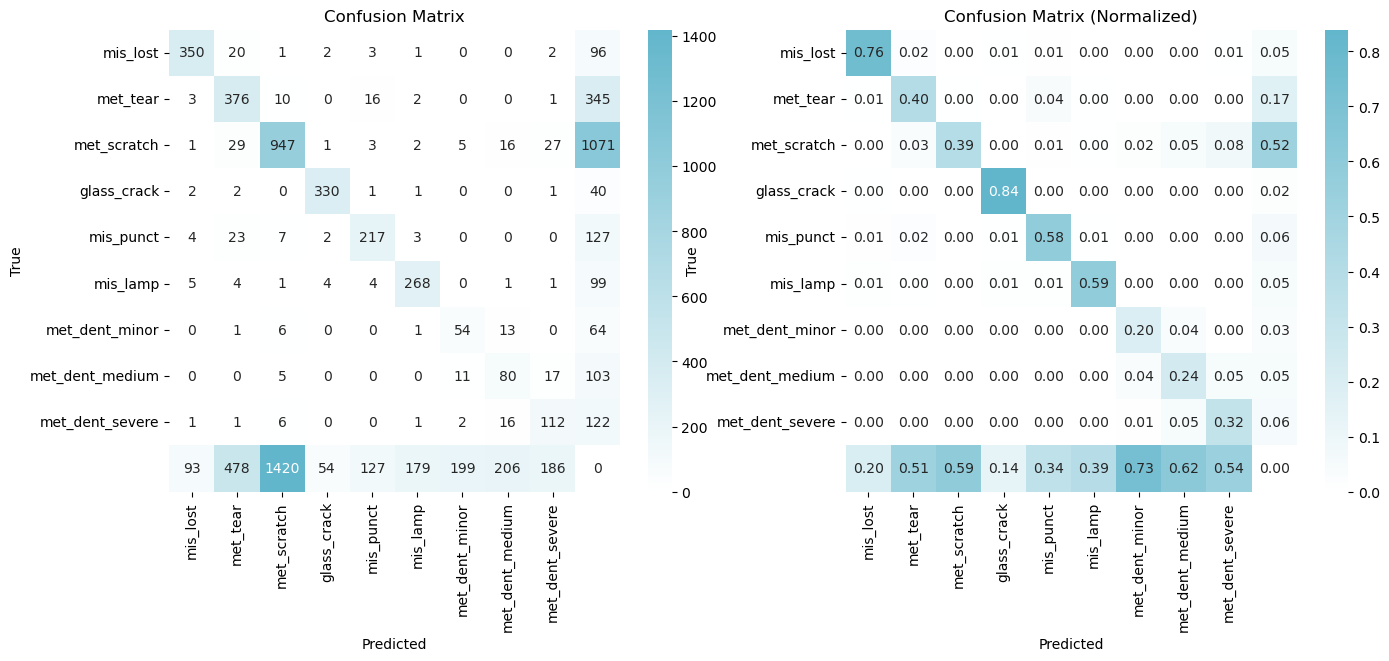

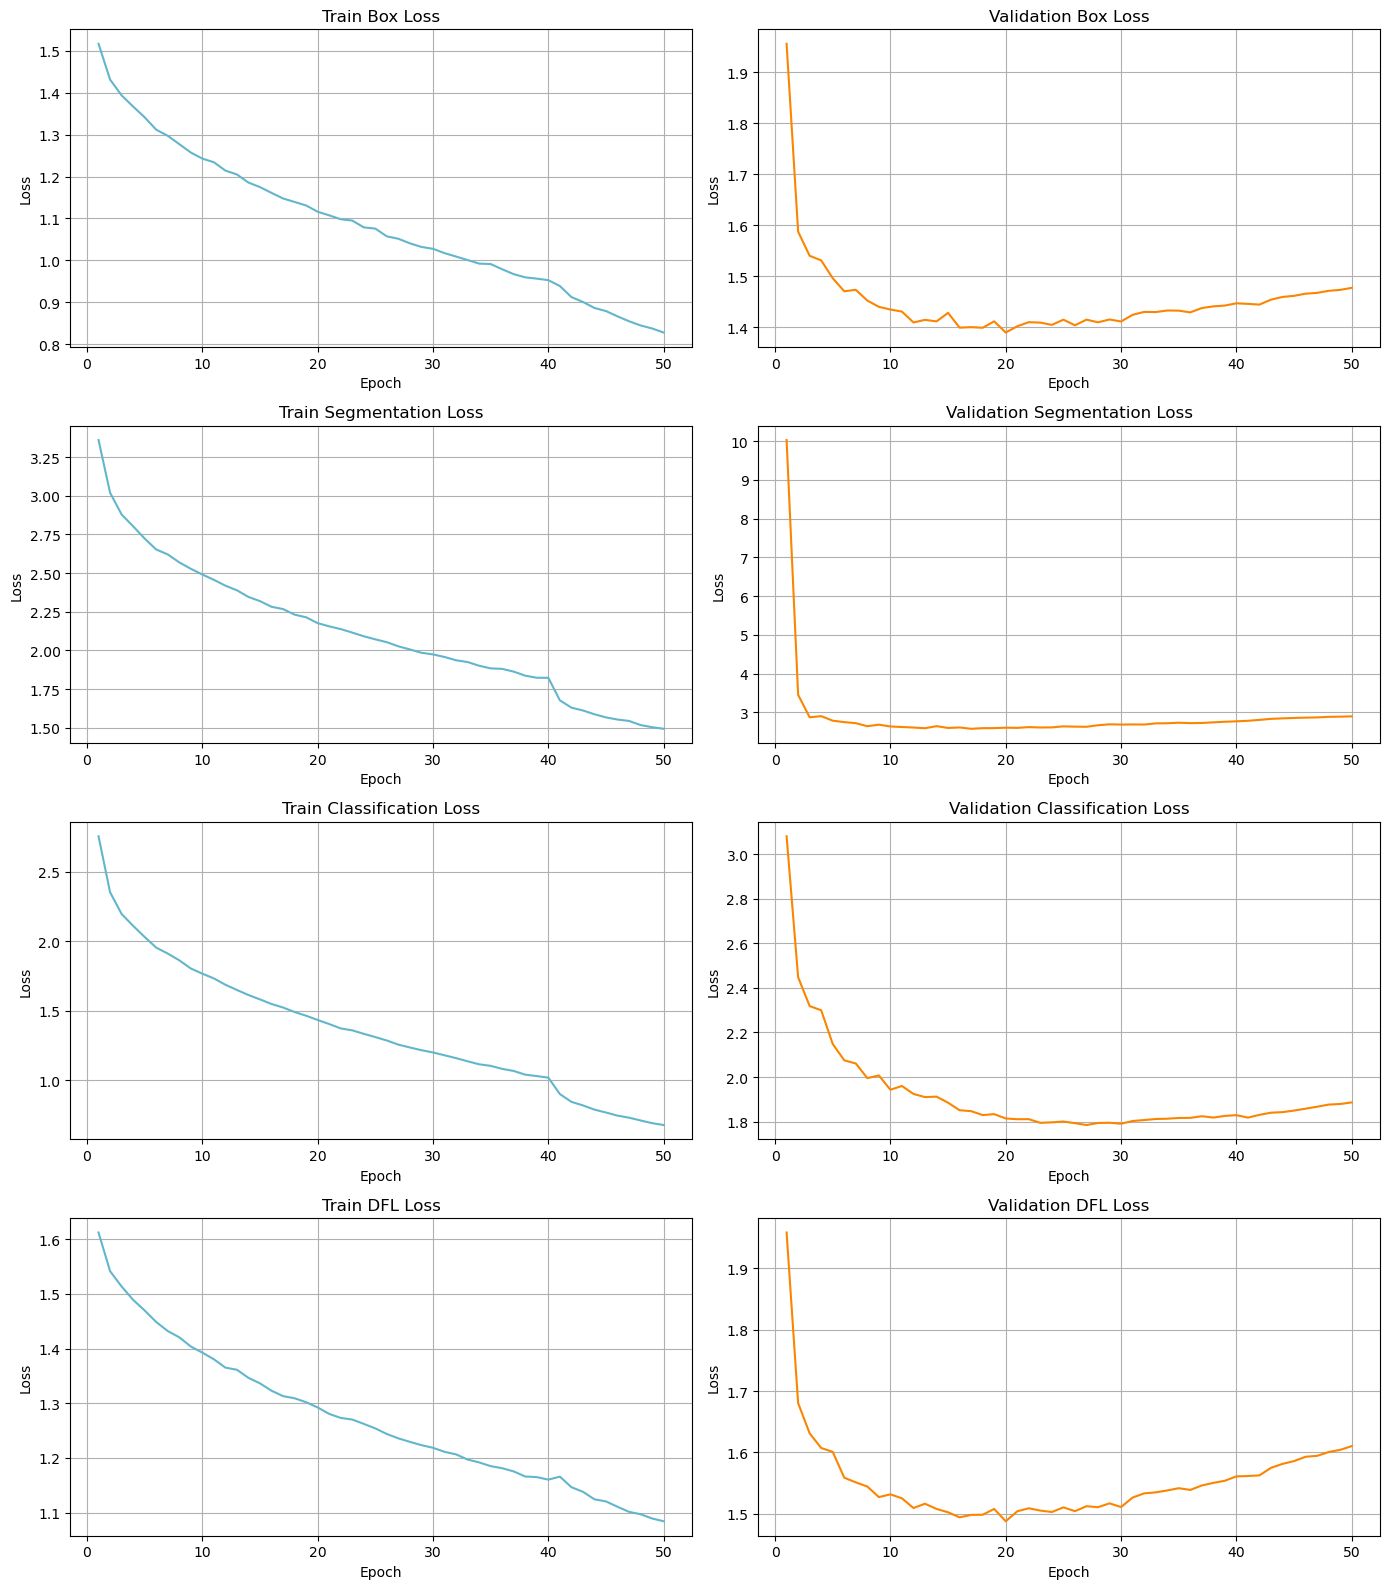

In [15]:
%matplotlib inline

# metrics_yolo(model = tuning_model, path_results_yolo = os.path.join(path_bestmodel, 'train'), color1 = color1, color2 = color2)
metrics_yolo(model = tuning_model, path_results_yolo = os.path.join(path_bestmodel, 'train'), color1 = color1, color2 = color2)
#In case of wanting delete the val folder

# if os.path.exists(path_yolo_val):
#     shutil.rmtree(path_yolo_val)

### <font color="#62b6cb"> 3. Train with the final model   <a name="id3"></a> 

### <font color="#62b6cb"> 3.1. Train and Validation Datasets for the final train <a name="id31"></a> 

When creating the YAML file for training with the validation and training sets merged, it's important to note that SageMaker does not allow the `val` path in the YAML file to be `null`. Therefore, it is necessary to have a `val` folder in the `final_data` directory that contains all the files used for training the final model.


In [16]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information

train_path = 'train/images'
path_yolo_val = 'val/images'

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)

# Create the YAML file
create_yaml_file(path_yaml_yolo_train_final, train_path, path_yolo_val, nc, names)


The yaml file is uploaded to s3 and also copied to the folder where the train is going to be done

In [17]:
# Upload the file to the specified S3 bucket
upload_file_to_s3(path_yaml_yolo_train_final, bucket_name)

Successfully uploaded ./Notebooks/data_train_final.yaml to s3://sagemaker-eu-west-1-project-danielteresa/data_train_final.yaml


In [18]:
# Copy data.yaml of s3 to tuning_data
s3 = boto3.resource('s3')
source_key = 'data_train_final.yaml'
destination_key = 'final_data/data_train_final.yaml'

# Copy the file to the new location
copy_source = {'Bucket': bucket_name, 'Key': source_key}
s3.Object(bucket_name, destination_key).copy(copy_source)

print(f"File copied from {source_key} to {destination_key}")

File copy from data_train_final.yaml to final_data/data_train_final.yaml


### <font color="#62b6cb"> 3.2. Retrain the Final Model in Sagemaker  <a name="id32"></a> 

We print the hyperparameters of the best modek in validation and we create a diccionary with it:

In [21]:
pd.DataFrame(results_df.iloc[0]).T

,lr0,lrf,momentum,weight_decay,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
Yolo-tuning24-001-9f30b400,"""0.0001""","""0.1""","""0.9""","""0.0001""",Completed,0.413141,2024-08-15 06:34:02+00:00,2024-08-15 10:52:13+00:00,15491.0


In [22]:
# Extract the first row as a dictionary
selected_params = results_df.iloc[0].to_dict()

# Remove non-hyperparameter keys
selected_params = {k: v for k, v in selected_params.items() if k in [ 'lr0', 'lrf', 'momentum', 'weight_decay']}

# Strip quotes and convert to appropriate types
selected_params = {
    k: int(v.strip('"')) if k == 'batch' else float(v.strip('"'))
    for k, v in selected_params.items()
}

print(selected_params)

{'lr0': 0.0001, 'lrf': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001}


In [23]:
metric_definitions = [
    {
        "Name": "box_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "cls_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "dfl_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "mAP50", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)\\s+\\d+\\.\\d+"
    },
    {
        "Name": "mAP50-95", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)"
    }
]

We redefine the **train_final.py*** to include `val = False` when training so that it doesn't perform a validation too.

In [25]:
%%writefile Sagemaker/train_final.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument('--patience',type=int, help='patience value')
    parser.add_argument("--batch", type=int, help='batch size')
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

    # Listar archivos en el directorio de entrenamiento

    # Train the YOLO model
    yolo_model = YOLO("yolov8m-seg.pt")

    # Definir manualmente la ruta al archivo YAML de datos
    data_yaml_path = os.path.join(args.train, "data_train_final.yaml")
    
    # Train the YOLO model with the full path to the YAML file
    yolo_model.train(data=data_yaml_path, 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     patience=args.patience,
                     task='segment',
                     project=args.runs_path,
                     val=False)
    
    yolo_model.export()


Overwriting Sagemaker/train_final.py


In [ ]:

# we define again the output path
train_data_path = f's3://{bucket_name}/final_data/'

output_path = f's3://{bucket_name}/output'

# we create the estimator with the final hyperparameters
estimator_train_final = PyTorch(
    entry_point="Sagemaker/train_final.py",
    role=role_arn,
    instance_count=1,
    instance_type='ml.p3.2xlarge', #GPU best for our problem
    # instance_type='ml.p3.2xlarge', #GPU best for our problem
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'optimizer': 'Adam',        
        'batch': 32,
        'epochs': 100,
        'patience': 30,
        # 'batch': selected_params['batch'], 
        'lr0': selected_params['lr0'],
        'lrf': selected_params['lrf'],
        'momentum': selected_params['momentum'],
        'weight_decay': selected_params['weight_decay']
    },
    use_spot_instances=False,
    max_run=3600 * 48, 
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)


# Run the training job with the selected hyperparameters
estimator_train_final.fit({"train": train_data_path}, job_name=final_jobname)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: YOLO-final4


2024-08-16 16:54:27 Starting - Starting the training job
2024-08-16 16:54:27 Pending - Training job waiting for capacity...
2024-08-16 16:54:56 Pending - Preparing the instances for training...
2024-08-16 16:55:28 Downloading - Downloading input data......

### <font color="#62b6cb"> 4. Generalization Check   <a name="id4"></a> 

We download the final model:

In [4]:
# stablish conexion with s3
s3 = boto3.client('s3')

# obtain the output folder of the final model
file = s3.list_objects_v2(Bucket=bucket_name, Prefix=f"output/{final_jobname}/output/output.tar.gz")
targz_finalmodel =  file['Contents'][0]['Key']
targz_finalmodel

'output/YOLO-final4/output/output.tar.gz'

In [5]:
# we create the path for the final model
path_finalmodel = os.path.join(path_models, f'{final_jobname}')

if os.path.exists(path_finalmodel):
    shutil.rmtree(path_finalmodel)
    os.makedirs(path_finalmodel)
else:
    os.makedirs(path_finalmodel)

# Download the .tar.gz file from S3
response = s3.get_object(Bucket=bucket_name, Key=targz_finalmodel)
tar_gz_data = response['Body'].read()
with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
    tar.extractall(path=path_finalmodel)

print(f"The final model has been extracted to {path_finalmodel}")

The final model has been extracted to ./Models/YOLO-final4


In [6]:
# charge the final model
final_model = YOLO(os.path.join(path_finalmodel, 'train/weights/best.pt'))

We download again all the photos to predict and calculate the metrics on the training

In [7]:
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name)

# folder with val and train images
path_s3_train_final ='train_final'
path_yolo_train_final = os.path.join(path_yolo, path_s3_train_final)

# if the folder exist we remove the existing one
if os.path.exists(path_yolo_train_final):
    shutil.rmtree(path_yolo_train_final)

for obj in bucket.objects.filter(Prefix = path_s3_train_final): 
        # check that the images and labels folder exits
        if not os.path.exists(os.path.join(path_yolo, os.path.dirname(obj.key))):
            os.makedirs(os.path.join(path_yolo , os.path.dirname(obj.key)))
        # save content of val folder of S3
        target = os.path.join(path_yolo, obj.key)
        bucket.download_file(obj.key, target) 
        
print(f"Number of images in final: {len(os.listdir(f'{path_yolo_train_final}/images'))} \n\n")

Number of images in final: 20918 




Predict and get the metric over the train dataset.

In [8]:
# create a yaml for the final model as yolo needs the absolute dir. and sometimes we are working in different computers 

# obtain the final classes
with open(os.path.join(path_annotations,test_annotations_name), 'r') as f:
    coco_data = json.load(f)
names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
nc = len(names)

path_yolo_train_final_abs =  os.path.join(os.getcwd(), f'{path_yolo_train_final}/images')
create_yaml_file(path_yaml_yolo_train_final_metrics, None,  path_yolo_train_final_abs , nc, names)

# calculate the results of the metrics for train final (the output will be store path_bestmodel+ train_final_metrics)
if os.path.exists(os.path.join(path_finalmodel, 'train_final_metrics')):
    shutil.rmtree(os.path.join(path_finalmodel, 'train_final_metrics'))

metrics = final_model.val(data = path_yaml_yolo_train_final_metrics, project =  os.path.join(os.getcwd(), os.path.join(path_finalmodel, 'train_final_metrics')))

Ultralytics YOLOv8.2.78 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 104MB/s]
val: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/labels... 20904 images, 0 backgrounds, 14 corrupt: 100%|██████████| 20918/20918 [00:17<00:00, 1178.78it/s]

val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/images/02012020_082351image833616.jpg: ignoring corrupt image/label: image file is truncated (21 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/images/04052020_152057image59498.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/images/04052020_152101image628633.jpg: ignoring corrupt image/label: broken data stream when reading image file
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/images/04052020_152107image748519.jpg: ignoring corrupt image/label: image file is truncated (0 bytes not processed)
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/images/11032020_143029image424625.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /home/sagemaker-user/proj

val: New cache created: /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train_final/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1307/1307 [46:21<00:00,  2.13s/it]


                   all      20904      54089      0.938      0.883      0.944      0.786      0.937      0.873      0.933      0.649
              mis_lost       3759       4281      0.965      0.964      0.987      0.907      0.967      0.962      0.984      0.824
              met_tear       5719       8152      0.922      0.868      0.936       0.78      0.916      0.852      0.916       0.53
           met_scratch      10475      22120      0.887      0.795      0.885      0.688      0.879      0.773      0.853      0.452
           glass_crack       3112       3243      0.975      0.979      0.993      0.934      0.976      0.976      0.988      0.845
             mis_punct       2850       3636       0.94      0.851      0.923       0.72      0.937      0.835      0.907      0.609
              mis_lamp       3593       4190      0.959      0.918      0.965      0.836      0.947      0.901      0.938      0.636
        met_dent_minor       2171       2431      0.917      0.763   

,Class Name,Box Precision,Box Recall,Box F1 Score,Box AP50,Box AP50-95,Segmentation Precision,Segmentation Recall,Segmentation F1 Score,Segmentation AP50,Segmentation AP50-95,Segmentation YOLO
0,mis_lost,0.9651,0.9636,0.9643,0.9866,0.9070,0.9669,0.9620,0.9644,0.9843,0.8239,0.9683
1,met_tear,0.9225,0.8681,0.8945,0.9359,0.7800,0.9163,0.8516,0.8827,0.9156,0.5299,0.8770
2,met_scratch,0.8872,0.7947,0.8384,0.8850,0.6880,0.8794,0.7733,0.8230,0.8531,0.4519,0.8130
3,glass_crack,0.9755,0.9793,0.9774,0.9933,0.9342,0.9757,0.9759,0.9758,0.9875,0.8450,0.9733
4,mis_punct,0.9402,0.8512,0.8935,0.9225,0.7195,0.9367,0.8347,0.8828,0.9072,0.6089,0.8774
5,mis_lamp,0.9587,0.9181,0.9380,0.9646,0.8363,0.9474,0.9007,0.9234,0.9377,0.6365,0.9076
6,met_dent_minor,0.9166,0.7631,0.8328,0.8756,0.6208,0.9245,0.7555,0.8315,0.8767,0.5535,0.8444
7,met_dent_medium,0.9246,0.8829,0.9033,0.9576,0.7609,0.9316,0.8791,0.9046,0.9565,0.6759,0.9284
8,met_dent_severe,0.9492,0.9263,0.9376,0.9755,0.8271,0.9531,0.9241,0.9384,0.9744,0.7170,0.9487
9,all,0.9377,0.8830,0.9096,0.9441,0.7860,0.9368,0.8730,0.9038,0.9326,0.6492,0.9042


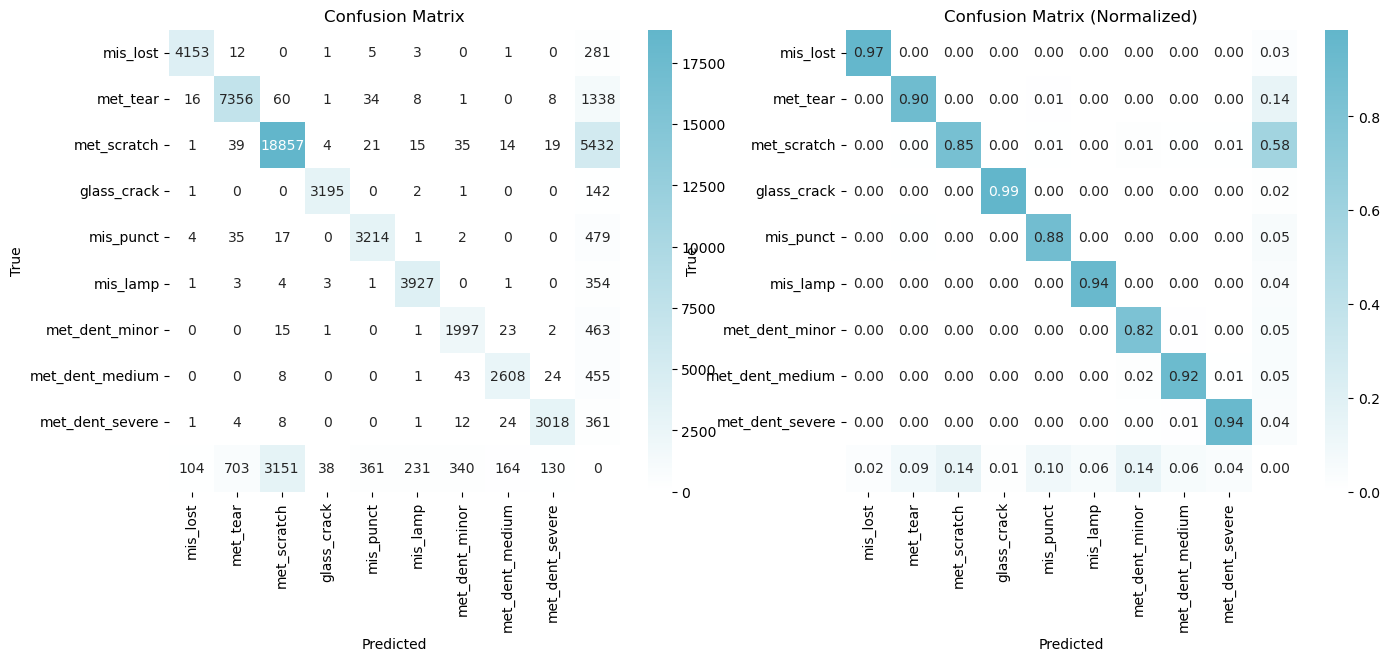

In [9]:
%matplotlib inline

# we print the metrics
metrics_yolo(model = final_model)

Now we download the test dataset with the YOLO structure to predict with the final model:

In [10]:
# Download the val folder from S3
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name)

#download the test data
path_s3_test ='test'
path_yolo_test = os.path.join(path_yolo, path_s3_test)

# if the folder exist we remove the existing one
if os.path.exists(path_yolo_test):
    shutil.rmtree(path_yolo_test)

for obj in bucket.objects.filter(Prefix = path_s3_test): 
        # check that the images and labels folder exits
        if not os.path.exists(os.path.join(path_yolo, os.path.dirname(obj.key))):
            os.makedirs(os.path.join(path_yolo , os.path.dirname(obj.key)))
        # save content of val folder of S3
        target = os.path.join(path_yolo, obj.key)
        bucket.download_file(obj.key, target) 
        
print(f"Number of images in test: {len(os.listdir(f'{path_yolo_test}/images'))} \n\n")

Number of images in test: 2325 




We create another yaml file for getting the test metrics:

In [11]:
# create a yaml for the tuning model as yolo needs the absolute dir. and sometimes we are working in different computers 

# obtain the val classes
with open(os.path.join(path_annotations,test_annotations_name), 'r') as f:
    coco_data = json.load(f)
names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information
nc = len(names)
path_yolo_test_abs =  os.path.join(os.getcwd(), f'{path_yolo_test}/images')
create_yaml_file(path_yaml_yolo_test, None,  path_yolo_test_abs , nc, names)

Predict and get the metric over the test dataset.

In [12]:
# calculate the results of the metrics for val (the output will be store path_bestmodel,\val)
if os.path.exists(os.path.join(path_finalmodel, 'test')):
    shutil.rmtree(os.path.join(path_finalmodel, 'test'))

metrics = final_model.val(data = path_yaml_yolo_test, project =  os.path.join(os.getcwd(), os.path.join(path_finalmodel,'test')))

Ultralytics YOLOv8.2.78 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8488C)


val: Scanning /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/labels... 2322 images, 0 backgrounds, 79 corrupt: 100%|██████████| 2324/2324 [00:01<00:00, 1504.05it/s]

val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/images/01042020_091351image21145.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0038]
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/images/01102020_135233image760694.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0267]
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/images/02012020_082149image965429.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0017]
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/images/02012020_095611image737458.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0035]
val: WARNING ⚠️ /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/images/02012020_095705image758065.jpg: ignoring corrupt image/label: non-normalized or out of boun


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 141/141 [04:46<00:00,  2.03s/it]


                   all       2245       5905      0.586      0.442      0.446       0.29      0.576      0.433      0.422      0.238
              mis_lost        395        440       0.75      0.649      0.683      0.538      0.762      0.657      0.688      0.479
              met_tear        651        953      0.509      0.357      0.345       0.22      0.499      0.349      0.329      0.154
           met_scratch       1113       2331      0.479      0.354      0.324      0.184      0.445      0.328      0.282      0.107
           glass_crack        339        355      0.855      0.784      0.837       0.65      0.837      0.766      0.804      0.549
             mis_punct        316        415      0.636      0.528      0.535      0.324      0.636      0.527      0.523      0.295
              mis_lamp        402        454      0.762      0.579      0.628      0.389      0.701      0.533      0.538      0.282
        met_dent_minor        225        253      0.418      0.186   

,Class Name,Box Precision,Box Recall,Box F1 Score,Box AP50,Box AP50-95,Segmentation Precision,Segmentation Recall,Segmentation F1 Score,Segmentation AP50,Segmentation AP50-95,Segmentation YOLO
0,mis_lost,0.7502,0.6485,0.6957,0.6827,0.5383,0.7617,0.6568,0.7054,0.6884,0.4789,0.6674
1,met_tear,0.5089,0.3568,0.4195,0.3454,0.2195,0.4988,0.3488,0.4105,0.3286,0.1535,0.3111
2,met_scratch,0.4793,0.3539,0.4072,0.3243,0.1844,0.4445,0.3275,0.3772,0.2817,0.1065,0.2642
3,glass_crack,0.8555,0.7837,0.8180,0.8369,0.6500,0.8369,0.7663,0.8000,0.8042,0.5493,0.7787
4,mis_punct,0.6356,0.5277,0.5767,0.5346,0.3236,0.6365,0.5274,0.5768,0.5225,0.2954,0.4998
5,mis_lamp,0.7620,0.5793,0.6582,0.6281,0.3887,0.7014,0.5330,0.6057,0.5382,0.2816,0.5126
6,met_dent_minor,0.4176,0.1858,0.2571,0.1447,0.0547,0.4279,0.1897,0.2629,0.1492,0.0445,0.1387
7,met_dent_medium,0.3587,0.1959,0.2534,0.1738,0.0893,0.3656,0.1988,0.2576,0.1689,0.0837,0.1604
8,met_dent_severe,0.5027,0.3453,0.4094,0.3440,0.1652,0.5075,0.3481,0.4129,0.3186,0.1474,0.3015
9,all,0.5856,0.4419,0.5037,0.4461,0.2904,0.5757,0.4329,0.4942,0.4223,0.2379,0.4038


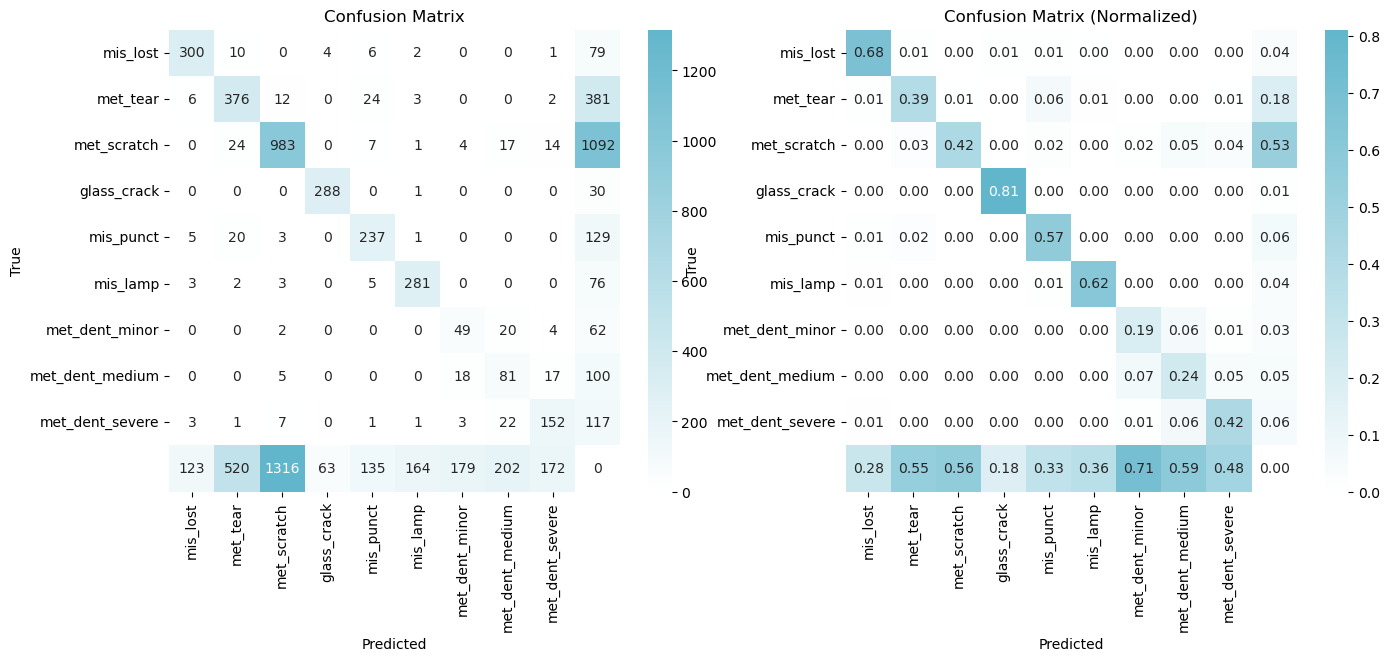

In [15]:
%matplotlib inline

# we print the metrics
metrics_yolo(model = final_model)

The final model is copied to folder Models to be able to use it in the Application.

In [14]:
# Define the source and destination paths
source_path = os.path.join(path_finalmodel, 'train/weights/best.pt')
destination_path = os.path.join(path_finalmodel, 'yolo_model.pt')

# Copy the file from the source to the destination
shutil.copy(source_path, destination_path)

print(f"File copied and renamed to {destination_path}")

File copied and renamed to ./Models/YOLO-final4/yolo_model.pt


## <font color="#62b6cb"> 5. Conclusions <a name="id1"></a>


Below are the results of the YOLO model for both the training and testing phases. The Segmentation YOLO metric consists of a weighted combination of the metrics mAP$ \text{mAP50} \times 0.9 + \text{mAP50-95} \times 0.1$. This metric was selected for decision-making because it is the same one YOLO uses to determine which epoch has produced the best results, allowing us to maintain consistency with the model's evaluation approach. We can observe that the difference between the training and testing results is significant, indicating that our model struggles to detect and classify car damage in cases it hasn't seen before. However, these results are not surprising given the high difficulty of the task, as the objects to be classified do not always have a consistent shape, and their detectability can be affected by external factors like paint color, reflections, etc. The easiest class to detect is mirror breakage.

Another factor that may have worsened our results is the dataset itself, as it contains images from Vietnamese cars, where the marked damages are often severe or sometimes hard to detect. Therefore, one potential improvement would be to enhance the dataset with new images that serve as better examples for this problem. Additionally, the most affected classes are those fragmented by severity, as they were classified by ourselves, and since we are not experts in the field, our basis for deciding each type may not have been optimal. Ideally, we should consult with car repair professionals to improve this aspect.

<table>
  <tr>
    <td><img src="../images_readme/testresults.jpg" alt="Test Results" width="400"/></td>
    <td><img src="../images_readme/trainresults.jpg" alt="Train Results" width="400"/></td>
  </tr>
</table>
